<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_CNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$: Derivada do torque do robô (variação do torque com o tempo).[R_d_T]
- $\tau_{r}$: Torque do robô [R_T].
- $S_Fx$: Sensor de torque Tx [R_Fx].
- $\omega_{l}$: Velocidade da coroa [R_w_l].
- $\theta_{l}$: Ângulo da coroa [R_t_l].
- $\theta_{m}$: Ângulo do motor [R_t_m].
- $\omega_{h}$: Velocidade da pessoa [R_w_p].
- $\theta_{h}$: Ângulo da pessoa [R_t_p].
- $∫e(Interacao).dt$: Integral do erro de torque [R_i_T_e].
- $U(x)$: Sinal de controle [R_u].
- $\tau^{d}_{r}$: Torque desejado do robô [R_T_d].
- $\tau_{i}$: Torque de interação [R_T_i].
- $\frac{d\omega_{l}}{dt}$: Derivada da velocidade da coroa  (variação da velocidade da coroa com o tempo). [R_d_w_l]
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$: Ângulo do motor na perna esquerda .[L_t_m]
- $\theta_{l, L}$: Ângulo da coroa na perna esquerda .[L_t_l]
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$: Torque real no lado esquerdo .[L_T_r]
- $\tau^{d}_{r, L}$: Torque desejado no lado esquerdo . [L_T_d]

#Bibliotecas

# 1º Passo: Montar o Drive e carregar o dataset


In [1]:
from scipy.signal import butter, filtfilt # Import butter and filtfilt

In [2]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Reshape, GRU, Attention
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
drive.mount('/content/drive')
t1_markov = "drive/MyDrive/Markov/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l',
               'R_t_l', 'R_w_p', 'R_t_p','R_i_T_e', 'R_u',
               'R_T_d', 'R_t_m', 'R_d_w_l', 'phase',
               'L_t_m','L_t_l', 'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t1 = pd.read_table(t1_markov, header=None, names=head_markov, index_col=False)

Mounted at /content/drive


In [4]:
data = markov_t1.iloc[1870:11760]

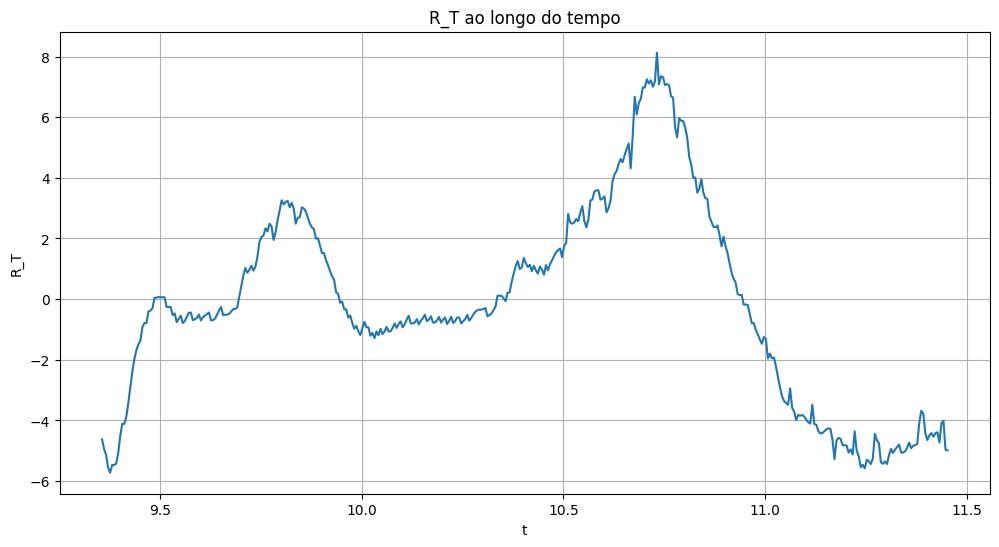

In [5]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(data['t'].iloc[:420], data['R_T'].iloc[:420])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

# 2º Passo: Cálculo do torque de interação τ_i

In [6]:
Ka = 200  # Rigidez do acessório
Ba = 10   # Amortecimento do acessório
data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
data['d_tau_i'] = np.gradient(data['tau_i'])

<ipython-input-6-ada45a1a3584>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
<ipython-input-6-ada45a1a3584>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['d_tau_i'] = np.gradient(data['tau_i'])


# 3º Passo: Separação e Normalização dos dados


In [7]:
dataset = data.copy()
X = dataset[['tau_i', 'd_tau_i', 'phase', 'R_T']]
y = dataset[['R_T']]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [8]:
timesteps = 420  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (9470, 420, 4)
Forma dos dados de saída: (9470, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [9]:
model_cnn_gru = Sequential()

# Camada CNN com BatchNorm e padding 'causal' para preservar temporalidade
model_cnn_gru.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     padding='causal', input_shape=(timesteps, n_features)))
model_cnn_gru.add(MaxPooling1D(pool_size=2))
model_cnn_gru.add(Dropout(0.2))

# Camada LSTM com return_sequences para empilhar
model_cnn_gru.add(GRU(128, return_sequences=True))
model_cnn_gru.add(Dropout(0.2))

# Camada LSTM final
model_cnn_gru.add(GRU(64, return_sequences=False))
model_cnn_gru.add(Dropout(0.2))

# Camada de saída (regressão - sem ativação)
model_cnn_gru.add(Dense(1))

# Compilação para regressão (usando Huber ou MSE)
model_cnn_gru.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=Huber(),  # Alternativa: 'mse'
    metrics=['MAE', 'MSE']
)

model_cnn_gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 420, 64)        │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 210, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 210, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 210, 128)       │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 210, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,641 (440.00 KB)

 Trainable params: 112,641 (440.00 KB)

 Non-trainable params: 0 (0.00 B)

# 6º Passo: Treinamento do Modelo

In [10]:
history = model_cnn_gru.fit(
    X_train, y_train,
    epochs=32,
    batch_size=32,
    validation_split=0.4,
    verbose=1
)

Epoch 1/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 92s 491ms/step - MAE: 0.1188 - MSE: 0.0331 - loss: 0.0166 - val_MAE: 0.0297 - val_MSE: 0.0015 - val_loss: 7.3247e-04
Epoch 2/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 155s 565ms/step - MAE: 0.0508 - MSE: 0.0043 - loss: 0.0021 - val_MAE: 0.0378 - val_MSE: 0.0021 - val_loss: 0.0010
Epoch 3/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 132s 508ms/step - MAE: 0.0481 - MSE: 0.0038 - loss: 0.0019 - val_MAE: 0.0246 - val_MSE: 0.0010 - val_loss: 5.1091e-04
Epoch 4/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 89s 501ms/step - MAE: 0.0444 - MSE: 0.0033 - loss: 0.0017 - val_MAE: 0.0349 - val_MSE: 0.0018 - val_loss: 9.1314e-04
Epoch 5/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 152s 561ms/step - MAE: 0.0441 - MSE: 0.0033 - loss: 0.0016 - val_MAE: 0.0211 - val_MSE: 7.9321e-04 - val_loss: 3.9661e-04
Epoch 6/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 133s 513ms/step - MAE: 0.0401 - MSE: 0.0027 - loss: 0.0013 - val_MAE: 0.0218 - val_MSE: 7.8004e-04 - val_loss: 3.9002e-04
Epoch 7/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 141s 510ms

# 7º Passo: Avaliação e Previsão

In [ ]:
def filter_predictions(predictions, low=0.1, high=10, fs=100):
    nyq = 0.5 * fs
    low = low / nyq
    high = high / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, predictions.flatten())

y_pred_scaled = model_cnn_gru.predict(X_train)
y_pred_scaled = y_pred_scaled.reshape((-1, 1))
y_pred_raw = scaler_y.inverse_transform(y_pred_scaled)
y_pred_filtered = filter_predictions(y_pred_raw)  # Aplica o filtro
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas adicionais
r2 = r2_score(y_train_rescaled, y_pred_filtered)
mae = mean_absolute_error(y_train_rescaled, y_pred_filtered)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred_filtered))

print(f'R²: {r2}')
print(f'MAE: {mae:.4f} Nm')
print(f'RMSE: {rmse:.4f} Nm')

296/296 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step
R²: 0.971022555870979
MAE: 0.3323 Nm
RMSE: 0.5131 Nm


# 8º Passo: Visualização das perdas (train vs validation)

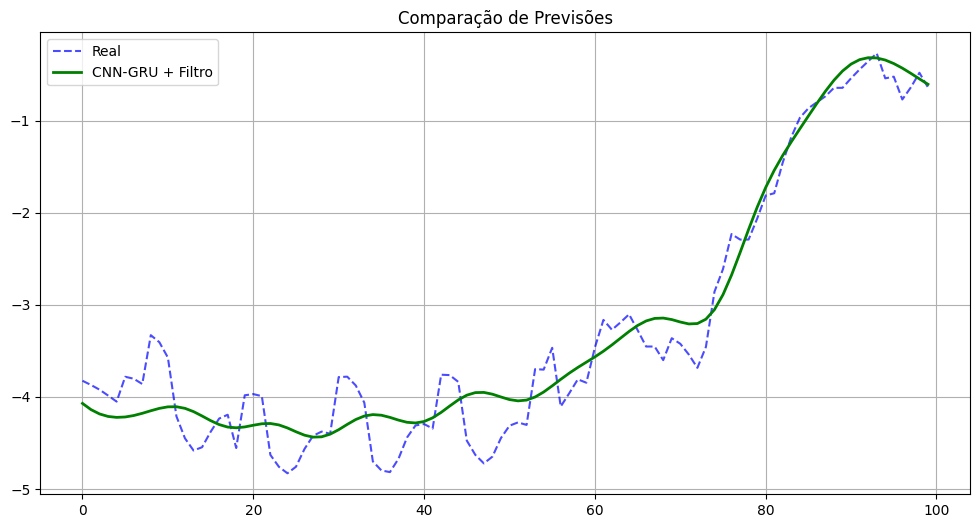

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_train_rescaled[4400:4500], 'b--', label='Real', alpha=0.7)
plt.plot(y_pred_filtered[4400:4500], 'g-', label='CNN-GRU + Filtro', linewidth=2)
plt.title('Comparação de Previsões')
plt.legend()
plt.grid(True)
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

In [ ]:
def calc_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr = np.corrcoef(y_true.flatten(), y_pred.flatten())[0,1]
    return r2, mae, rmse, corr

r2, mae, rmse, corr = calc_metrics(y_train_rescaled, y_pred_filtered)
print(f'R²: {r2:.4f} | MAE: {mae:.4f}Nm | RMSE: {rmse:.4f}Nm | Corr: {corr:.4f}')

R²: 0.9710 | MAE: 0.3323Nm | RMSE: 0.5131Nm | Corr: 0.9856


# 10º Passo: Erro

In [ ]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred_raw.flatten()

#11º Passo: Plot do Erro

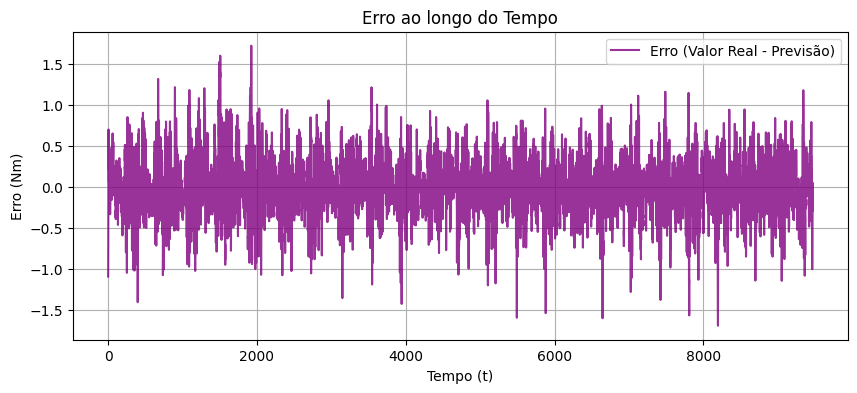

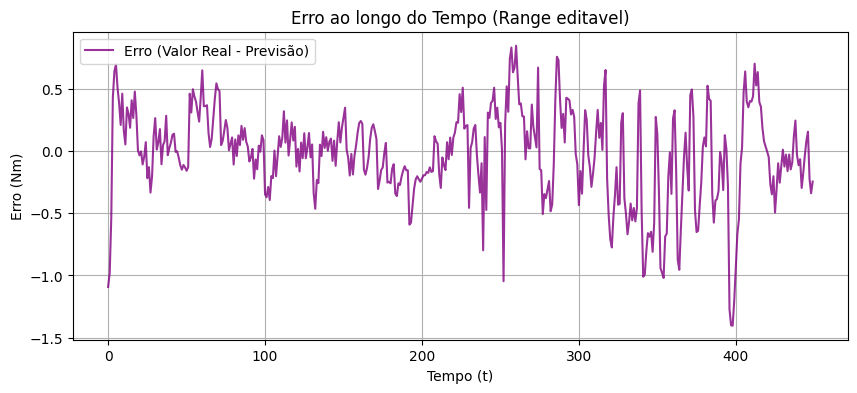

Média do Erro: -0.0155 Nm
Desvio Padrão do Erro: 0.3457 Nm


In [ ]:
# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(erro[:], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(erro[:450], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')